# Classifiny Penguins

[Penguins dataset](https://www.openml.org/d/42585)

<img src="https://imgur.com/orZWHly.png" alt="Penguin species in the dataset" width="800"/>

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
import seaborn as sns
import dill

In [2]:
# Fetch the Penguins dataset from OpenML:
dataset = fetch_openml('penguins', as_frame=False)

In [3]:
# Extract only the "culmen length", "culmen depth", and "flipper length" features:
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm']]

In [4]:
# Add the target column:
df['species'] = pd.Series(dataset.target).astype('category')

In [5]:
# Drop rows with null values:
df.dropna(axis=0, inplace=True, how='any')

In [6]:
df

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,species
0,39.1,18.7,181.0,Adelie
1,39.5,17.4,186.0,Adelie
2,40.3,18.0,195.0,Adelie
4,36.7,19.3,193.0,Adelie
5,39.3,20.6,190.0,Adelie
...,...,...,...,...
338,47.2,13.7,214.0,Gentoo
340,46.8,14.3,215.0,Gentoo
341,50.4,15.7,222.0,Gentoo
342,45.2,14.8,212.0,Gentoo


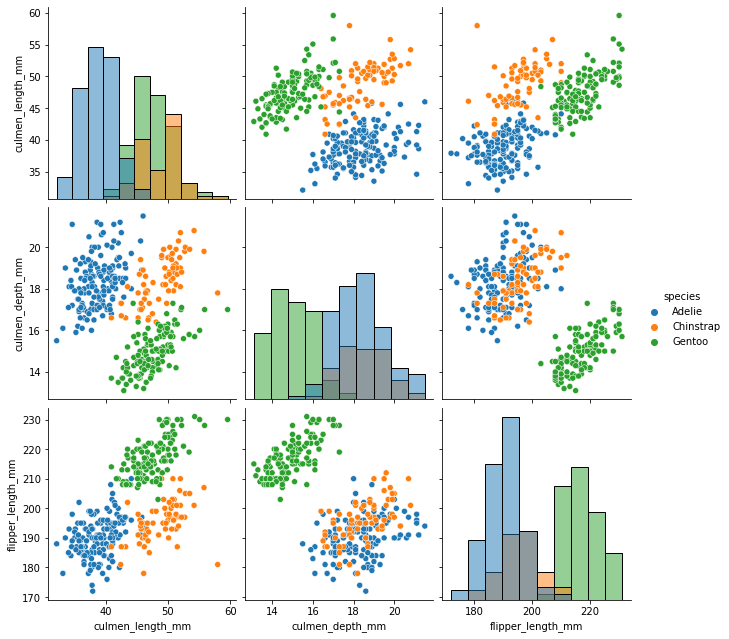

In [7]:
sns.pairplot(df, hue="species", height=3, diag_kind="hist");

In [8]:
# Index-encode the categories:
target_dict = {i: c for i, c in enumerate(df.species.cat.categories)}
df['species'] = df.species.cat.codes

In [9]:
target_dict

{0: 'Adelie', 1: 'Chinstrap', 2: 'Gentoo'}

In [10]:
# Split in training and test sets:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='species'), df.species, test_size=0.2, stratify=df.species, random_state=42)

In [11]:
# Export a sample of the test set:
# X_test.sample(n=10, random_state=42).to_csv('./test sample.csv', header=False, index=False)

X_test.to_csv('./test sample.csv', header=False, index=False)

XY_test = pd.concat([X_test, y_test], axis=1)
XY_test.species = XY_test.species.apply(lambda x:target_dict[x])
XY_test.to_csv('./test sample 2.csv', index=False)
XY_test.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,species
151,41.5,18.5,201.0,Adelie
1,39.5,17.4,186.0,Adelie
294,46.4,15.0,216.0,Gentoo
336,44.5,15.7,217.0,Gentoo
158,46.1,18.2,178.0,Chinstrap


In [12]:
%%time
# Train a random forest using cross-validation:
rf = GridSearchCV(
    RandomForestClassifier(),
    cv=5,
    param_grid={
        'n_estimators': range(10, 30, 5),
        'max_depth': range(4, 9),
        'min_samples_leaf': [1, 2, 4, 10]
    }
)

rf.fit(X_train, y_train)

CPU times: user 9.43 s, sys: 157 ms, total: 9.58 s
Wall time: 9.71 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(4, 9),
                         'min_samples_leaf': [1, 2, 4, 10],
                         'n_estimators': range(10, 30, 5)})

In [13]:
rf.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'n_estimators': 25}

In [14]:
rf.best_score_

0.9816835016835016

In [15]:
accuracy_score(y_train, rf.predict(X_train))

0.9926739926739927

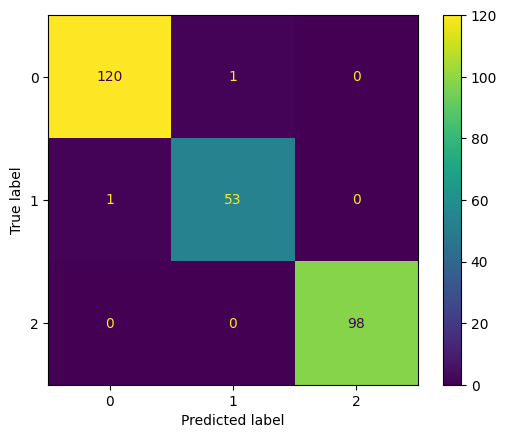

In [16]:
plot_confusion_matrix(rf, X_train, y_train)

In [17]:
accuracy_score(y_test, rf.predict(X_test))

1.0

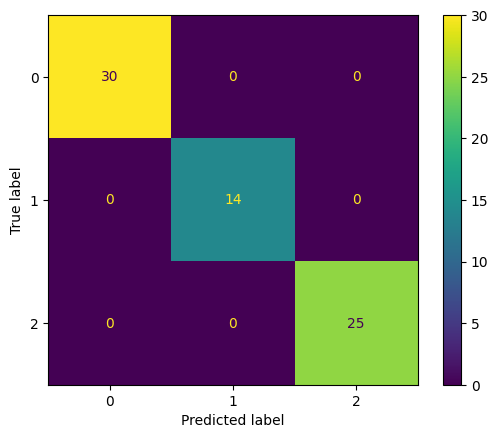

In [18]:
plot_confusion_matrix(rf, X_test, y_test)

In [19]:
# Export (pickle) the model:
with open('./model.dill', 'wb') as fopen:
    dill.dump(rf.best_estimator_, fopen)